Lens Modeling for DESIJ1537+1443

Author(s): Md. Mehedi Hasan, Anowar J. Shajib




In [ ]:
import h5py
import lenstronomy
import joblib
import numpy as np
import corner
import matplotlib.pyplot as plt

%matplotlib inline

Loading Data from h5 Files

In [ ]:
with h5py.File('DESIJ1537+1443_F140W.h5', 'r') as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]

image_data = kwargs_data['image_data']



with h5py.File('psf_F140W.h5', 'r') as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]

kwargs_psf['psf_type'] = 'PIXEL'

Loading Imaging Data

<ipython-input-5-fbd634adef56>:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix');


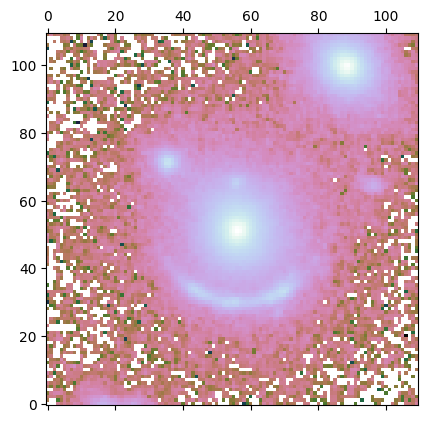

In [ ]:
plt.matshow(np.log10(image_data), origin='lower', cmap='cubehelix');

Creating Mask

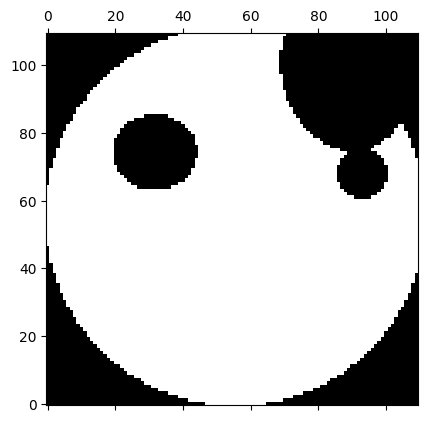

<ipython-input-6-c6c4d157757f>:66: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(masked_image_data),
<ipython-input-6-c6c4d157757f>:66: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(masked_image_data),


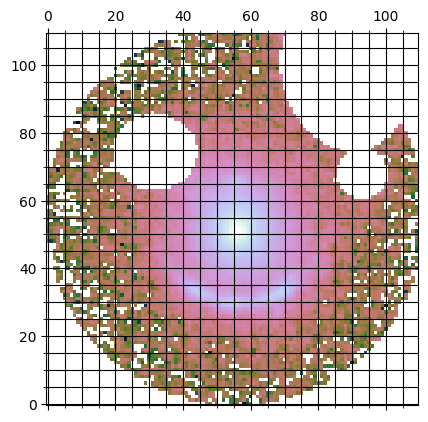

In [ ]:
from lenstronomy.Util import mask_util
from lenstronomy.Util import util
from lenstronomy.Data.coord_transforms import Coordinates


ra_at_xy_0 = kwargs_data['ra_at_xy_0']
dec_at_xy_0 = kwargs_data['dec_at_xy_0']
transform_pix2angle = kwargs_data['transform_pix2angle']

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data['image_data'])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)


r = 4.5 # In Arcseconds
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra +0,
    lens_center_dec +0,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords)
)


mask_ext_1 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra - 2.6,
                                   lens_center_dec +3.4,
                                   1.5, 1.9, 6)


mask_ext_2 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra  -3,
                                   lens_center_dec +1,
                                   0.6, 0.6, 0)


mask_ext_3 = mask_util.mask_ellipse(util.image2array(x_coords),
                                   util.image2array(y_coords),
                                   lens_center_ra + 1.9,
                                   lens_center_dec + 1.5,
                                   1, 0.9, 0)





mask = (1 - mask_outer) * (1- mask_ext_1) * (1- mask_ext_2) * (1- mask_ext_3)

mask[mask >= 1] = 1
mask[mask < 0] = 0

mask = mask.reshape(num_pix, num_pix)

plt.matshow(mask, origin='lower', cmap='cubehelix')
plt.show()

# Masking Image Data
masked_image_data = np.multiply(image_data, mask)

plt.matshow(np.log10(masked_image_data),
            origin='lower', cmap='cubehelix')
plt.grid(which='both', color='black')
plt.minorticks_on()
plt.grid(which='minor', color='black')
plt.show()

Lens Modeling with Lenstronomy

In [ ]:
lens_model_list = ["EPL", "SHEAR"]

source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]

lens_light_model_list = ["SERSIC_ELLIPSE"]

Model Fitting with the Created Mask using **Lenstronomy**

In [ ]:
#Lens Galaxy's Mass Model

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})
fixed_lens.append({'ra_0': 0, 'dec_0': 0})

kwargs_lens_init.append(
        {
          'theta_E': 1.,
          'gamma': 2.,
          'e1': 0.,
          'e2': 0.,
          'center_x': 0.,
          'center_y': 0.
          }
  )

kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.})





kwargs_lens_sigma.append(
    {
        'theta_E': .2,
        'gamma': .1,
        'e1': 0.05,
        'e2': 0.05,
        'center_x': 0.5,
        'center_y': 0.5
        }
    )

kwargs_lens_sigma.append(
    {'gamma1': 0.1, 'gamma2': 0.1}
    )

kwargs_lower_lens.append(
    {
        'theta_E': 0.01,
        'gamma': 1.,
        'e1': -0.5,
        'e2': -0.5,
        'center_x': -10,
        'center_y': -10
        }
    )

kwargs_lower_lens.append(
    {'gamma1': -0.3, 'gamma2': -0.3}
    )

kwargs_upper_lens.append(
    {
        'theta_E': 10.,
        'gamma': 3.,
        'e1': 0.5,
        'e2': 0.5,
        'center_x': 10,
        'center_y': 10
        }
    )

kwargs_upper_lens.append(
    {'gamma1': 0.3, 'gamma2': 0.3}
    )


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens
    ]

# Lens Galaxy's Light Model

fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({'n_sersic': 4.})


kwargs_lens_light_init.append(
    {
        'R_sersic': 0.5,
        'n_sersic': 2,
        'e1': 0,
        'e2': 0,
        'center_x': 0.,
        'center_y': 0,
        'amp': 16
        }
    )

kwargs_lens_light_sigma.append(
    {
        'n_sersic': 1,
        'R_sersic': 0.3,
        'e1': 0.05,
        'e2': 0.05,
        'center_x': 0.1,
        'center_y': 0.1,
        'amp': 10
        }
    )


kwargs_lower_lens_light.append(
    {
        'e1': -0.5,
        'e2': -0.5,
        'R_sersic': 0.001,
        'n_sersic': .5,
        'center_x': -10,
        'center_y': -10,
        'amp': 0
        }
    )

kwargs_upper_lens_light.append(
    {
        'e1': 0.5,
        'e2': 0.5,
        'R_sersic': 10,
        'n_sersic': 5.,
        'center_x': 10,
        'center_y': 10,
        'amp': 100
        }
    )



joint_lens_with_light = [[0, 0, ['center_x', 'center_y', 'e1', 'e2']]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light
    ]



# Source Galaxy's Light Model

fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({'n_sersic': 1.})
fixed_source.append({'n_max': 6})

kwargs_source_init.append(
    {
        'R_sersic': 0.2,
        'n_sersic': 1,
        'e1': 0,
        'e2': 0,
        'center_x': 0.,
        'center_y': 0,
        'amp': 16
        }
    )

kwargs_source_init.append(
    {'beta': 3,
     'center_x': 0,
     'center_y': 0
     }
    )


kwargs_source_sigma.append(
    {'n_sersic': 0.5,
     'R_sersic': 0.1,
     'e1': 0.08,
     'e2': 0.07,
     'center_x': 0.2,
     'center_y': 0.2,
     'amp': 10
     }
    )

kwargs_source_sigma.append(
    {
        'beta': 2,
        'center_x': 0.2,
        'center_y': 0.2
        }
    )



kwargs_lower_source.append(
    {
        'e1': -0.5,
        'e2': -0.5,
        'R_sersic': 0.001,
        'n_sersic': .5,
        'center_x': -10,
        'center_y': -10,
        'amp': 0
        }
    )

kwargs_lower_source.append(
    {
        'beta': 0,
        'center_x': -10,
        'center_y': -10
        }
    )

kwargs_upper_source.append(
    {'e1': 0.5,
     'e2': 0.5,
     'R_sersic': 10,
     'n_sersic': 5.,
     'center_x': 10,
     'center_y': 10,
     'amp': 100,
     }
    )

kwargs_upper_source.append(
    {
        'beta': 5,
        'center_x': 10,
        'center_y': 10
        }
    )



joint_source_with_source = [[0, 1,['center_x', 'center_y']]]

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source, kwargs_upper_source
    ]


# Combining Everything in `kwargs_params` Dictionary
kwargs_params = {
    'lens_model': lens_params,
    'source_model': source_params,
    'lens_light_model': lens_light_params
    }


kwargs_constraints = {
    'joint_lens_with_light': joint_lens_with_light,
    'joint_source_with_source' : joint_source_with_source
    }


In [ ]:
kwargs_likelihood = {
    'check_bounds': True,
    'image_likelihood_mask_list': [mask]
    }


kwargs_numerics = {
    'supersampling_factor': 1,
    'supersampling_convolution': False
                   }

In [ ]:
kwargs_model = {
    'lens_model_list': lens_model_list,
    'source_light_model_list': source_model_list,
    'lens_light_model_list': lens_light_model_list
    }


multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]


kwargs_data_joint = {
    'multi_band_list': multi_band_list,
    'multi_band_type': 'single-band'
                    }

The Model Fitting

In [ ]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence


fitting_seq = FittingSequence(
    kwargs_data_joint, kwargs_model,
    kwargs_constraints, kwargs_likelihood, kwargs_params
    )


fitting_kwargs_list = [
    ['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 100}],
        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0817092008314972 reduced X^2 of best position
-4556.159153902267 log likelihood
8424 effective number of data points
[{'theta_E': 1.5414647686154523, 'gamma': 2.190318716980715, 'e1': -0.06344279020936658, 'e2': 0.030827875226695927, 'center_x': -0.06771323023414667, 'center_y': -0.341891370721378}, {'gamma1': 0.08165505598735669, 'gamma2': -0.0010938855741943836, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.27069516053797493, 'n_sersic': 1.0, 'e1': 0.27046041526256387, 'e2': 0.1979169644644116, 'center_x': -0.14200296124904552, 'center_y': -0.7509046670331703}, {'amp': 1, 'n_max': 6, 'beta': 0.03634820384117229, 'center_x': -0.14200296124904552, 'center_y': -0.7509046670331703}] source result
[{'amp': 1, 'R_sersic': 0.7021818610004645, 'n_sersic': 4.0, 'e1': -0.06344279020936658, 'e2': 0.030827875226695927, 'center_x': -0.06771323023414667, 'center_y': -0.341891370721378}] lens li

In [ ]:
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed()

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

output = [kwargs_result, multi_band_list_out, chain_list, kwargs_fixed_out]

output_path = "./DESIJ1537+1443_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

Visualizing the Fitted Model

-1.0759615387156396 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.075961538715641


<ipython-input-13-5a232c4e1128>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


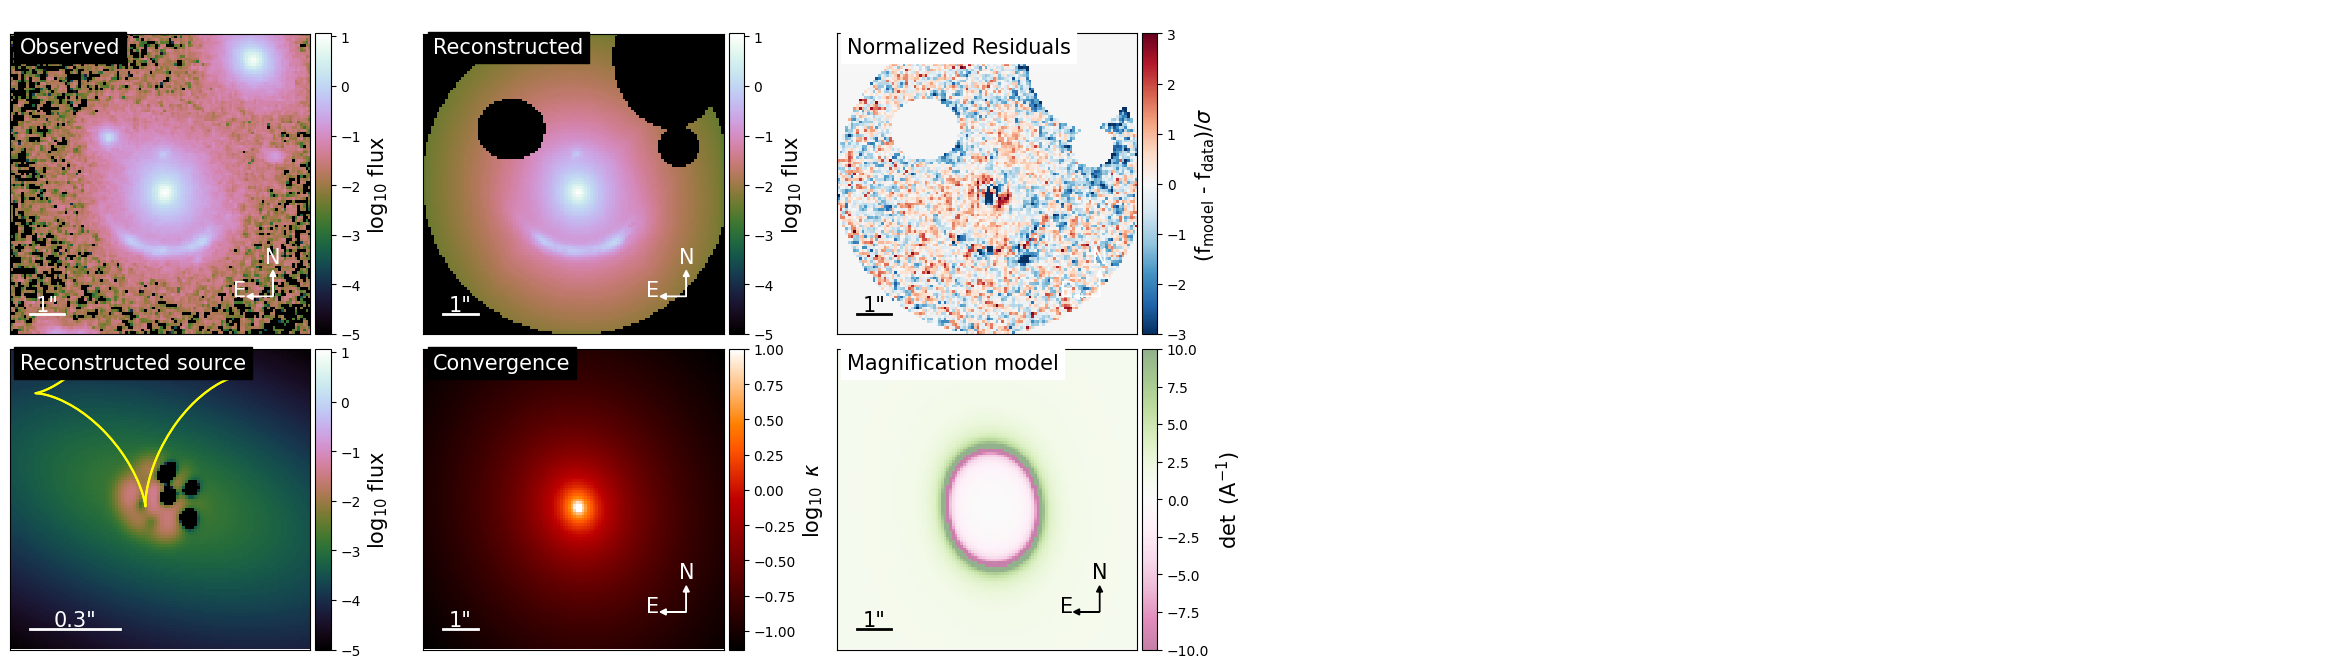

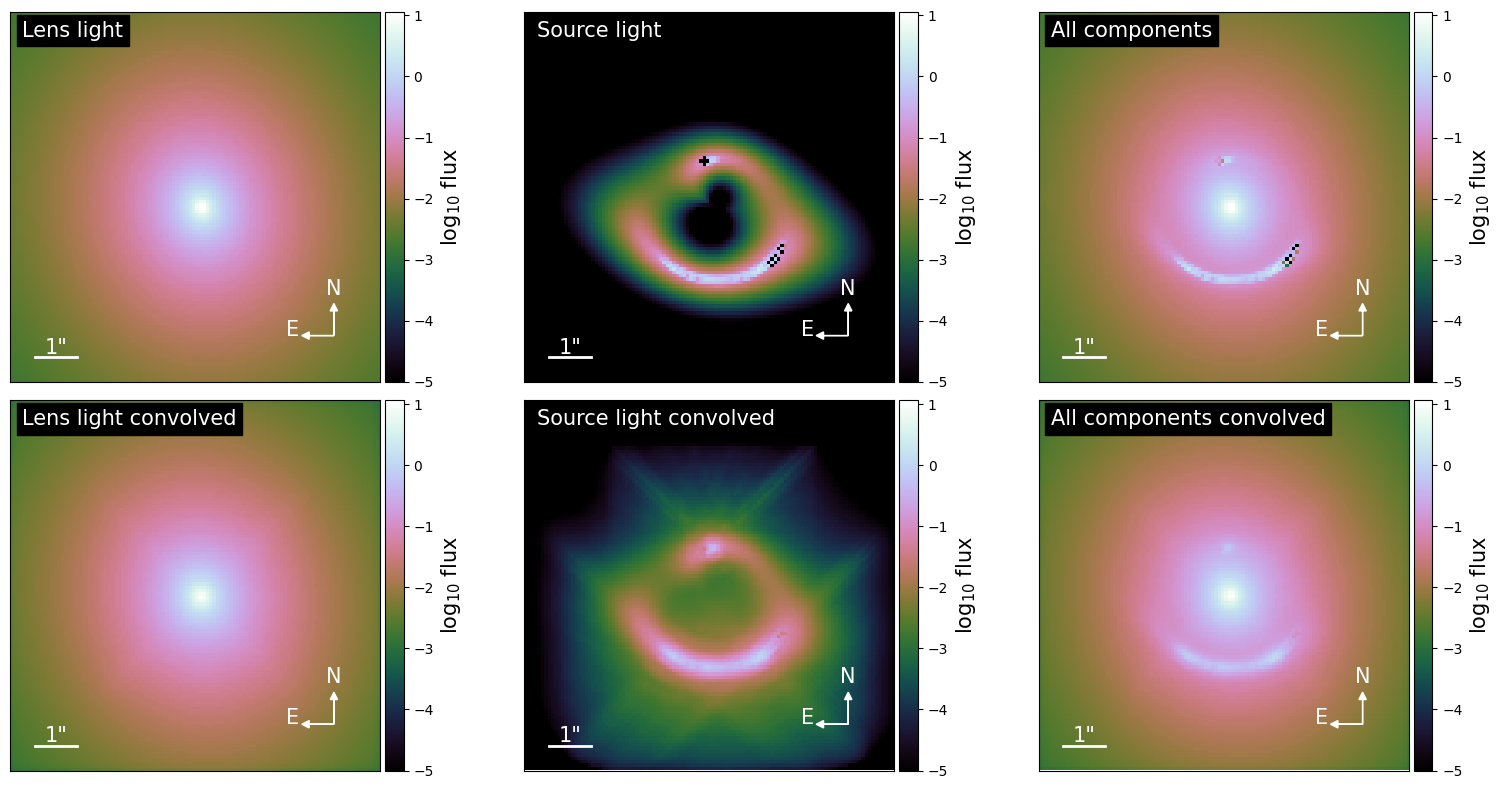

{'kwargs_lens': [{'theta_E': 1.5414647686154523, 'gamma': 2.190318716980715, 'e1': -0.06344279020936658, 'e2': 0.030827875226695927, 'center_x': -0.06771323023414667, 'center_y': -0.341891370721378}, {'gamma1': 0.08165505598735669, 'gamma2': -0.0010938855741943836, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 6.08023296237598, 'R_sersic': 0.27069516053797493, 'n_sersic': 1.0, 'e1': 0.27046041526256387, 'e2': 0.1979169644644116, 'center_x': -0.14200296124904552, 'center_y': -0.7509046670331703}, {'amp': array([ 320.47625963,  342.36864512, -156.79947011,  123.78449352,
        181.7090395 ,  216.79974476,  -27.23865662,   58.34032817,
        -75.69165281, -152.83902434,  140.97273569,  -52.15304355,
         57.52286797,   67.2292435 ,   15.16974231,  335.25552978,
         55.90913145,  158.8522848 ,   44.39577108,   48.58856223,
        -49.4103146 ,  142.55823958,   61.25500136,  -19.95002835,
       -129.3795416 ,   45.58762888,   95.05502628,  134.5209316 ]), 'n_max': 6, 'be

In [ ]:
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
    linear_solver=kwargs_constraints.get("linear_solver", True)
  )

f, axes = plt.subplots(
    2, 3, figsize=(16, 8),
    sharex=False,
    sharey=False
    )

modelPlot.data_plot(ax=axes[0,0])

modelPlot.model_plot(ax=axes[0,1])

modelPlot.normalized_residual_plot(
    ax=axes[0,2], v_min=-3,
    v_max=3, cmap='RdBu_r'
    )

modelPlot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.01,
    numPix=100,  with_caustics=True,
    scale_size=0.3
    )

modelPlot.convergence_plot(
    ax=axes[1, 1], v_max=1, cmap='gist_heat'
    )

modelPlot.magnification_plot(ax=axes[1, 2], cmap='PiYG')

f.tight_layout()

f.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05
    )

plt.show()

f, axes = plt.subplots(
    2, 3, figsize=(16, 8), sharex=False, sharey=False
    )

modelPlot.decomposition_plot(
    ax=axes[0,0], text='Lens light',
    lens_light_add=True, unconvolved=True
    )

modelPlot.decomposition_plot(
    ax=axes[1,0], text='Lens light convolved',
    lens_light_add=True
    )

modelPlot.decomposition_plot(
    ax=axes[0,1], text='Source light',
    source_add=True, unconvolved=True
    )

modelPlot.decomposition_plot(
    ax=axes[1,1], text='Source light convolved', source_add=True
    )

modelPlot.decomposition_plot(
    ax=axes[0,2], text='All components',
    source_add=True, lens_light_add=True, unconvolved=True
    )

modelPlot.decomposition_plot(
    ax=axes[1,2], text='All components convolved',
    source_add=True, lens_light_add=True, point_source_add=True
    )

f.tight_layout()

f.subplots_adjust(
    left=None, bottom=None, right=None,
    top=None, wspace=0., hspace=0.05
    )

plt.show()
print(kwargs_result)